## Importations

In [6]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import spacy
import fr_core_news_md

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Configuration

In [7]:
nlp = fr_core_news_md.load()

In [8]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [9]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

## Utilitaires

In [10]:
def export_df(df, name):
    df.to_csv('output/{}_{}.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d'), name), index=False, encoding='utf-8-sig')

In [17]:
def sent_to_words(sentences):
    for sent in sentences:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True) ) 

In [22]:
def process_words(texts, stop_words=nlp.Defaults.stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [25]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

## Données

In [11]:
df_articles = pd.read_sql_query("""SELECT id, title FROM article_article WHERE published = '1' AND EXTRACT(year FROM displaydate) = '2019'""", engine)
df_articles.head()

id                                              title
0  8194878  Cette semaine, quelques recettes de pâtes à ta...
1  8326326              Du gaspacho et de la tatin de tomates
2  8473505              La soupe paysanne de Laurent Mariotte
3  8600916  Produits de chez nous pour la Noël, quelques a...
4  9073377  Recette de Candice : Croq-Gaufres feuilletées ...

In [12]:
df_articles.count()

id       71680
title    71680
dtype: int64

In [13]:
df_articles.shape

(71680, 2)

In [84]:
df_articles.isnull().any()

id       False
title    False
dtype: bool

---
## Tokenizing 

In [54]:
df_subset = df_articles.copy()

In [55]:
data = df_subset.title.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['cette', 'semaine', 'quelques', 'recettes', 'de', 'pates', 'tartiner', 'maison']]


In [57]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
data_ready = process_words(data_words)  # processed Text Data!

In [86]:
tmp = pd.read_csv('output/200831_articles_tokenized_titles.csv', encoding='utf-8-sig')
data_ready = tmp['word_list'].apply(lambda x: x.strip("']['").split(', '))

In [87]:
data_ready

0                                                         [atteindre', 'sommet]
1                                                                            []
2                                                      [recette', 'simplissime]
3                             [an', 'maman', 'rentre', 'lhistoire', 'remporter]
4                                                           [epaule', 'confite]
                                          ...                                  
71675    [manifestant', 'coler', 'rentrer', 'lambassade', 'americain', 'accuse]
71676                                  [rendez', 'pensai', 'oublier', 'marcher]
71677                                     [tempo', 'cle', 'lorchestre', 'video]
71678                      [bel', 'echou', 'realise', 'meilleur', 'performance]
71679                                                    [permettre', 'accorde]
Name: word_list, Length: 71680, dtype: object

In [88]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready if len(text) ]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=60, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

KeyboardInterrupt: 

In [ ]:
lda_model.save('lda.model')

In [51]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.3749   
1            1             0.0              0.1246   
2            2             0.0              0.1246   
3            3             0.0              0.1246   
4            4             0.0              0.7072   
5            5             5.0              0.5294   
6            6             2.0              0.5431   
7            7             0.0              0.1246   
8            8             0.0              0.1246   
9            9             0.0              0.1246   

                                                                                      Keywords  \
0                 recette, candice, belge, auteur, editeur, civet, foie, gras, biche, crevette   
1                 recette, candice, belge, auteur, editeur, civet, foie, gras, biche, crevette   
2                 recette, candice, belge, auteur, editeur, civet, foie, gras, biche, crevette   
3                 recette, candice, belge, auteur, editeur, civet, foie, gras, biche, crevette   
4                 recette, candice, belge, auteur, editeur, civet, foie, gras, biche, crevette   
5  star, original, americain, ancien, television, deschanel, drole, parodie, dardenne, presque   
6                   coup, semaine, pedophilie, envoi, donne, sommet, enfumage, eau, namur, ptb   
7                 recette, candice, belge, auteur, editeur, civet, foie, gras, biche, crevette   
8                 recette, candice, belge, auteur, editeur, civet, foie, gras, biche, crevette   
9                 recette, candice, belge, auteur, editeur, civet, foie, gras, biche, crevette   

                                             Text  
0      [semaine, recette, pate, tartiner, maison]  
1                              [gaspacho, tomate]  
2                                 [soupe, paysan]  
3              [produit, adresse, incontournable]  
4  [recette, candice, gaufre, poulet, mozzarella]  
5                          [star, meilleur, amie]  
6                          [coup, oeil, fin, ete]  
7                    [terrasse, jardin, terrasse]  
8                      [participer, duel, cadeau]  
9                       [rose, parfait, munstead]

In [42]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.6822   
1        2.0              0.5251   
2        5.0              0.5250   
3       19.0              0.5251   

                                                                                      Keywords  \
0                   recette, candice, auteur, belge, editeur, civet, foie, gras, biche, salade   
1               coup, envoi, sommet, pedophilie, donne, ptb, enfumage, square, reponder, namur   
2  star, original, americain, ancien, television, deschanel, drole, parodie, dardenne, presque   
3          semaine, absent, nature, gagner, incertain, snooze, viver, risque, important, foret   

                                                                          Representative Text  
0                                              [recette, candice, gaufre, poulet, mozzarella]  
1                                 [suspect, recherche, coup, feu, tirer, voie, public, saint]  
2                                                                      [star, meilleur, amie]  
3  [enfant, combattant, djihadiste, papillomavirus, test, aptitude, conduire, semaine, viver]

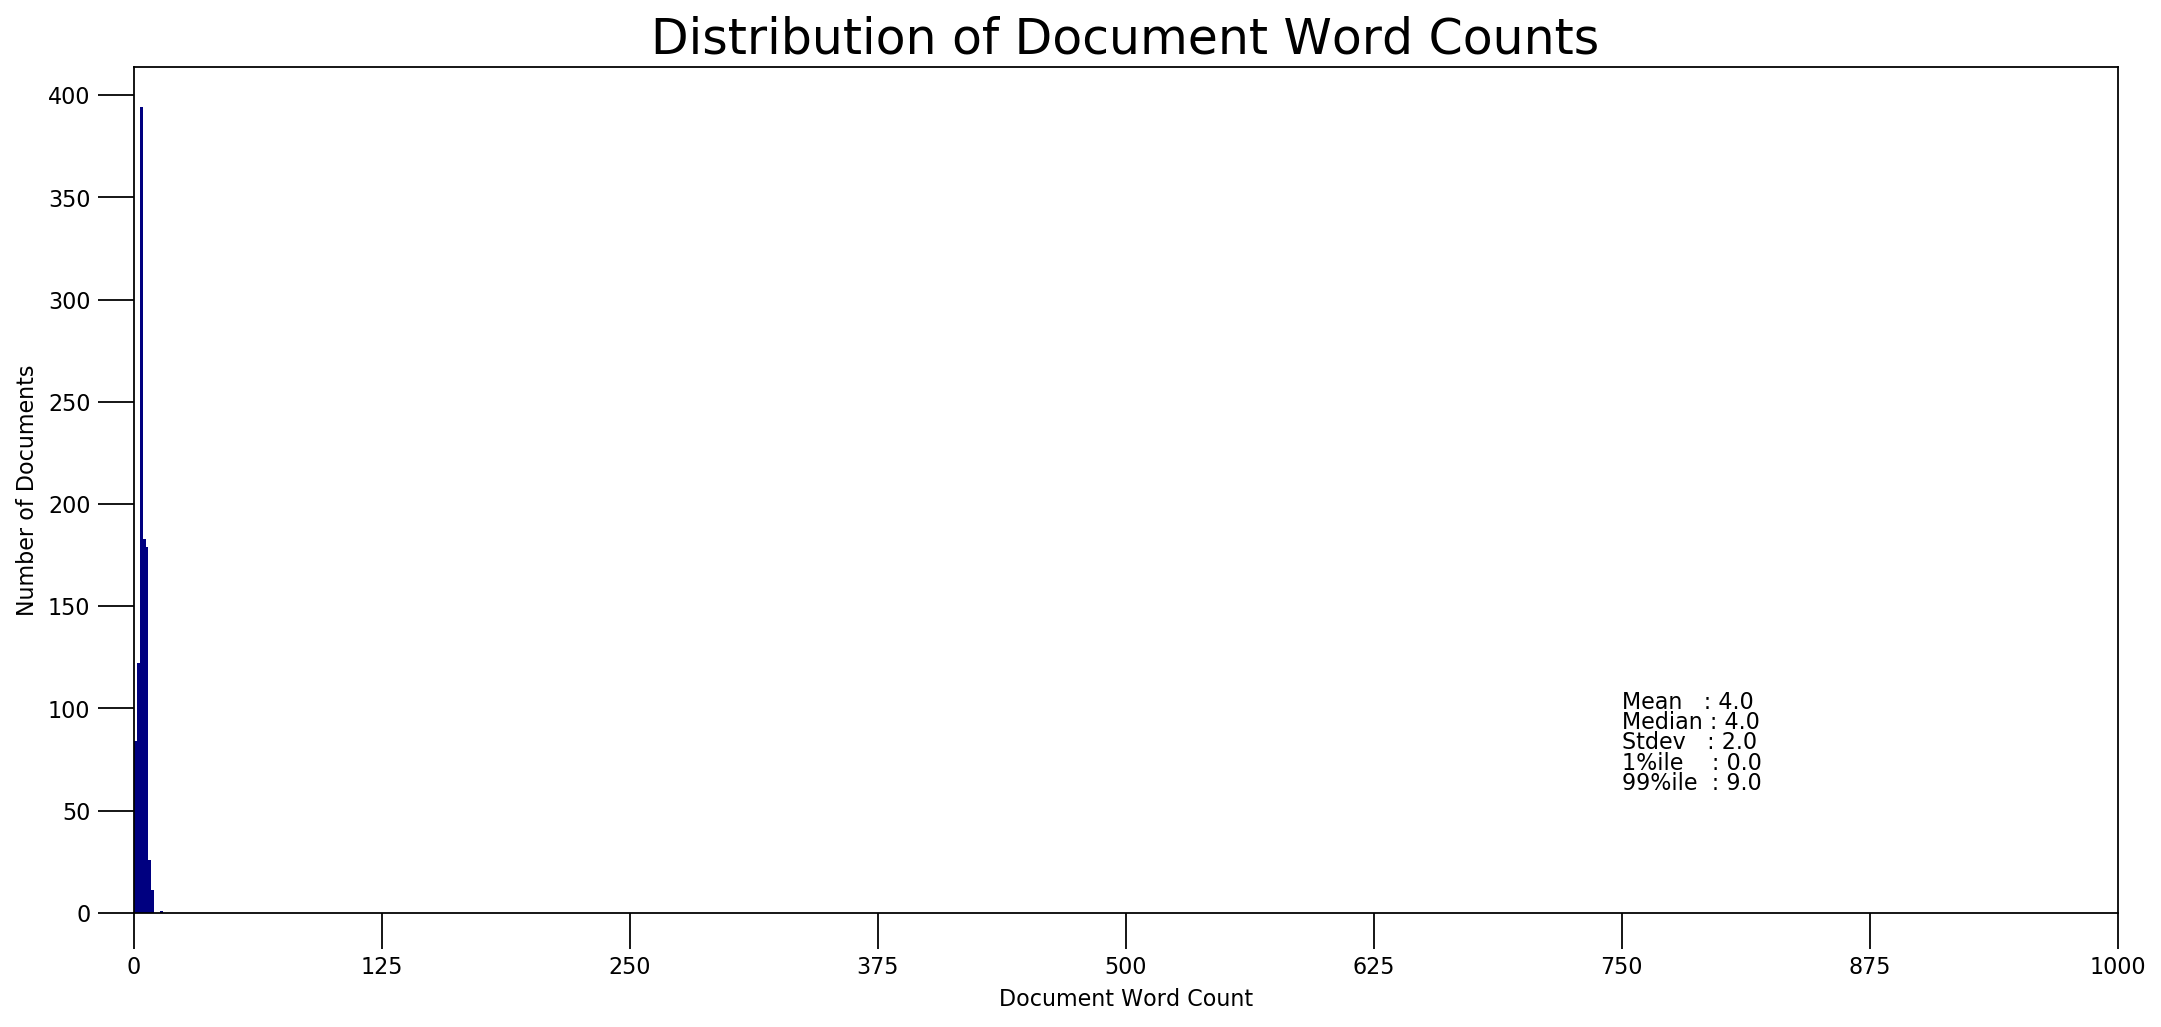

In [53]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [52]:
df_dominant_topic['Dominant_Topic'].unique()

array([0., 5., 2.])

In [ ]:
export_df(df_dominant_topic, )